In [ ]:

# env imports
from google.colab import files

# main imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow import keras


# helper libraries
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix



## UPLOAD DATA FILE 


I changed the encoding of the original dataset from Latin-1 to Utf-8 because python uses it as a default encoding to avoid any unforeseen errors. Download the modified dataset bellow.

Link to data https://drive.google.com/open?id=13Rqh3Rt1O33UCb_yB6Hv9J28LBZx7GwZ

original data source: https://www.kaggle.com/uciml/sms-spam-collection-dataset


In [ ]:
# upload data file
uploaded = files.upload()

Saving spam-utf-8.csv to spam-utf-8 (1).csv


## FORMAT DATA

The following snippet shows the steps I take to preprocess my data. I beguine by filtering out unnecessary fields, then renamed the columns and created two separate sets. First consisting of message bodies and second of labels reformatted to represent labels “ham” and “spam” in binary form of 0 and 1.


In [ ]:

# print your data
data = pd.read_csv(io.BytesIO(uploaded['spam-utf-8.csv']))

## drop unused columns
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

# rename columns labals and sms
data = data.rename(columns={"v1":'label', "v2":'message'})

# transform labels into binary format 

tags = {'spam': 1,'ham': 0}

data.label = [tags[item] for item in data.label]

# set labels
labels = data["label"]

# set messages
messages = data["message"]

# print data preview
print(data.head(10))

   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
5      1  FreeMsg Hey there darling it's been 3 week's n...
6      0  Even my brother is not like to speak with me. ...
7      0  As per your request 'Melle Melle (Oru Minnamin...
8      1  WINNER!! As a valued network customer you have...
9      1  Had your mobile 11 months or more? U R entitle...


## VECTORIZE MESSAGE DATA

Code modified from example in official Sklearn library Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

The following snippet describes the process of turning string messages into TFIDF (term frequency–inverse document frequency) vectors with a resizable number of features. These vector representations are then stored in an array and are ready to be feed into the Neural Net.


In [ ]:

# initialize vectorizer
vectorizer = TfidfVectorizer()

# adjust number of features
numOfFeatures = 1000

# initialize vectorizer
vectorizer = TfidfVectorizer(max_features=numOfFeatures)

# vectors created from input messages
vectors = vectorizer.fit_transform(messages).toarray()

# set number of number of vectors made
lenOfData = vectors.shape[0]

# preview 
print(" Features #",numOfFeatures,"\n","Data Points #",lenOfData)


 Features # 1000 
 Data Points # 5572


## CREATE TRAIN/TEST DATA

In [ ]:
# Split training data set random states and test size.

X_train,X_test,Y_train,Y_test = train_test_split(vectors,labels,random_state=30,test_size=0.1)



## NEURAL NET MODEL


he following Code snippet is my TensorFlow and Keras implementation of my Neural Net. Consisting of an input layer a hidden layer and an output layer along with two dropout layers. The input shape is the size of our vector representation and the number of features we use to express our message.


In [ ]:
# keras model

model = keras.models.Sequential()

# Dense interconected layer 
model.add(keras.layers.Dense(500,activation='sigmoid',input_shape=(numOfFeatures,)))

# Dropout to prevent overfitting
model.add(keras.layers.Dropout(0.3, input_shape=(numOfFeatures,)))

# Dense interconected layer 
model.add(keras.layers.Dense(250,activation='sigmoid'))

# Dropout to prevent overfitting
model.add(keras.layers.Dropout(0.4, input_shape=(numOfFeatures,)))

# use sigmoid for binary output
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 251       
Total params: 626,001
Trainable params: 626,001
Non-trainable params: 0
_________________________________________________________________


## TRAIN MODEL

In [ ]:
trainedModel = model.fit(X_train, Y_train, epochs=10,batch_size=50, validation_split=0.3)

Train on 3509 samples, validate on 1505 samples
Epoch 1/10
3509/3509 [==============================] - 1s 161us/sample - loss: 0.4490 - acc: 0.8541 - val_loss: 0.3912 - val_acc: 0.8591
Epoch 2/10
3509/3509 [==============================] - 0s 111us/sample - loss: 0.3801 - acc: 0.8652 - val_loss: 0.3532 - val_acc: 0.8591
Epoch 3/10
3509/3509 [==============================] - 0s 119us/sample - loss: 0.3064 - acc: 0.8720 - val_loss: 0.2243 - val_acc: 0.8711
Epoch 4/10
3509/3509 [==============================] - 0s 110us/sample - loss: 0.1689 - acc: 0.9399 - val_loss: 0.1167 - val_acc: 0.9568
Epoch 5/10
3509/3509 [==============================] - 0s 106us/sample - loss: 0.0995 - acc: 0.9667 - val_loss: 0.0781 - val_acc: 0.9787
Epoch 6/10
3509/3509 [==============================] - 0s 119us/sample - loss: 0.0715 - acc: 0.9801 - val_loss: 0.0910 - val_acc: 0.9728
Epoch 7/10
3509/3509 [==============================] - 0s 111us/sample - loss: 0.0571 - acc: 0.9801 - val_loss: 0.0614 - va

## EVALUATION


              precision    recall  f1-score   support

Not Spam "0"       0.99      1.00      0.99       497
    Spam "1"       0.96      0.90      0.93        61

    accuracy                           0.99       558
   macro avg       0.98      0.95      0.96       558
weighted avg       0.99      0.99      0.99       558



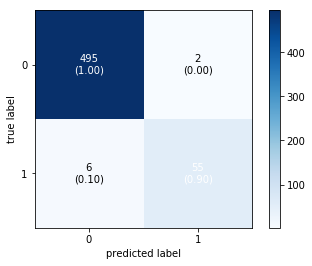

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

# get list of predictions from test messages
allPredictions = model.predict_classes(X_test)

# labels for binary output.
targetNames = ['Not Spam "0"', 'Spam "1"']

# classification report
print(classification_report(Y_test,allPredictions,target_names=targetNames))

# get confusion Matrix
confusionMatrix = confusion_matrix(Y_test,allPredictions)

# display confusion Matrix
binary = np.array(confusionMatrix)

labels = ['NOT SPAM', 'SPAM']
fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,)

plt.show()


## TRAINING LOSS VS VALIDATION LOSS

If your training loss much smaller then validation loss then network overfitting occurs. Solutions to this is to decrease your network size, or to increase dropout. I Increased dropout by 0.1 in each layer and also shortened epochs from 20 to 10 to prevent further overfitting.

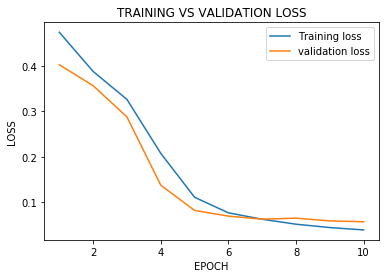

In [ ]:
# Training loss vs validation loss graph

trainLoss = trainedModel.history['loss']
valLoss = trainedModel.history['val_loss']

epochs = range(1,11)

plt.title('TRAINING VS VALIDATION LOSS')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')

plt.plot(epochs,trainLoss,label='Training loss')
plt.plot(epochs,valLoss,label='validation loss')

plt.legend()
plt.show()

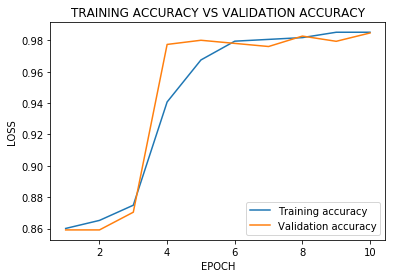

In [ ]:
# Training accuracy vs validation accuracy graph

accValues = trainedModel.history['acc']
valAccalues = trainedModel.history['val_acc']

plt.title('TRAINING ACCURACY VS VALIDATION ACCURACY')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')

plt.plot(epochs,accValues,label='Training accuracy')
plt.plot(epochs,valAccalues,label='Validation accuracy')

plt.legend()
plt.show()

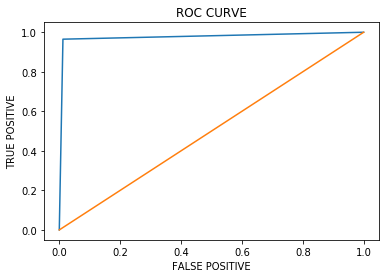

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute ROC Curve based on  fpr, tpr, thresholds and auc 

plt.title('ROC CURVE')
plt.xlabel('FALSE POSITIVE')
plt.ylabel('TRUE POSITIVE')

fpr, tpr, thresholds = roc_curve(allPredictions, Y_test, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.show() 

## TEST CUSTOM PREDICTIONS
Function tests your own messages against the Neural Network Model

Input your own test "SMS" messages to test.



In [ ]:
# function for testing custom messages against the trained model

def testNN_Model(model,message):
  
  vector = vectorizer.transform([message]).toarray()
  
  prediction = model.predict_classes(vector)
  
  if prediction == 1:
    
    print("SPAM")
    
  else:
    
    print("NOT SPAM")

In [ ]:


## Test classifier Neural Net on custom messages

messageInput =  "Your family won a amazing trip to las vegas text 4567 to claim your prize now"

messageInput2 =  "Can you buy me doritos on your way home."

testNN_Model(model,messageInput)

testNN_Model(model,messageInput2)


SPAM
NOT SPAM
